In [97]:
from utils import get_hyperedges, get_data
from model import CustomLoss

# Pyomo Solver

In [322]:
# from pyomo.environ import (
#     ConcreteModel, Var, Objective, ConstraintList, SolverFactory, NonNegativeReals, Binary, maximize
# )
# # Step 2: Create Pyomo model
# model = ConcreteModel()

# # Step 3: Define binary decision variables for each link (b_i)
# model.b = Var(range(V_H), domain=Binary)  # b[i] = 1 if link i is active, 0 otherwise

# # Step 4: Define the objective function (maximize throughput)
# def throughput(model):
#     total_throughput = 0
#     for i in range(V_H):
#         interference = sum(model.b[j] * I[i, j] for j in range(V_H) if j != i)  # Interference from other active links
#         denominator = N[i] + interference  # Noise + interference
#         total_throughput += (I[i,i] * model.b[i]) / denominator  # Contribution of link i to throughput
#     return total_throughput

# model.obj = Objective(rule=throughput, sense=maximize)

# # Step 5: Add constraints for hyperedges (each hyperedge has a threshold)
# model.constraints = ConstraintList()

# for e_idx, hyperedge in enumerate(hyperedges):
#     model.constraints.add(
#         sum(model.b[i] for i in hyperedge) <= len(hyperedge)-1
#     )

# # Step 6: Solve the model
# solver = SolverFactory('ipopt')  # Use Ipopt for nonlinear problems
# result = solver.solve(model, tee=True)

# # Step 7: Extract the results
# optimal_decisions = [model.b[i].value for i in range(V_H)]

# # Output the optimal link schedule
# print("Optimal link schedule:", optimal_decisions)
# print("Maximum throughput:", model.obj())

# Generate data

In [181]:
import numpy as np

# Step 1: Define problem parameters
V_H = 10  # Number of nodes (links)
E_H = 5   # Number of hyperedges
N = 0.1  # Noise power
theta = 0.5  # Thresholds for hyperedges
k = 4  # max hyperedge cardinality
train_samples = 5000
test_samples = 50
batch_size = 100


In [182]:
itens_train, hlist_train = get_data(train_samples, V_H, N, theta, k)
itens_test, hlist_test = get_data(test_samples, V_H, N, theta, k)

# Exhaustive Search Solver

In [183]:
# exhaustive search
def exh_solver(V_H, E_H, N, I, hyperedges):
    best_throughput = 0
    best_schedule = None

    for i in range(2**V_H):
        schedule = [int(x) for x in bin(i)[2:].zfill(V_H)]
        throughput = 0

        # check if the schedule satisfies the hyperedge constraints
        valid_schedule = True
        for hyperedge in hyperedges:
            if sum(schedule[j] for j in hyperedge) == len(hyperedge):
                valid_schedule = False
                break
        
        if not valid_schedule:
            continue

        # calculate throughput
        for i in range(V_H):
            interference = sum(schedule[j] * I[i, j] for j in range(V_H) if j != i)
            denominator = N[i] + interference
            throughput += (I[i,i] * schedule[i]) / denominator
        
        if throughput > best_throughput:
            best_throughput = throughput
            best_schedule = schedule

    return best_throughput, best_schedule
        

In [184]:
best_throughput_test = []
for I, hyperedges in zip(itens_test, hlist_test):
    best_throughput, best_schedule = exh_solver(V_H, E_H, V_H*[N], I, hyperedges)
    best_throughput_test.append(best_throughput)
    print("Exhaustive search results:")
    print("Optimal link schedule:", best_schedule)
    print("Maximum throughput:", best_throughput)
print(f"Mean average throughput: {np.mean(best_throughput_test)}")

Exhaustive search results:
Optimal link schedule: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Maximum throughput: 8.143717475566374
Exhaustive search results:
Optimal link schedule: [1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Maximum throughput: 10.003396640326972
Exhaustive search results:
Optimal link schedule: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Maximum throughput: 9.010348602901153
Exhaustive search results:
Optimal link schedule: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Maximum throughput: 9.695275788832808
Exhaustive search results:
Optimal link schedule: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Maximum throughput: 9.993692244954213
Exhaustive search results:
Optimal link schedule: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Maximum throughput: 9.344727645282102
Exhaustive search results:
Optimal link schedule: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Maximum throughput: 9.018706177513216
Exhaustive search results:
Optimal link schedule: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Maximum throughput: 9.743272822716612
Exhaustive search results:
Optimal link schedul

# Learning-Based

# Data Preparation

Format of Data Should be as follows
Dictionary Keys: "$n$": Number of hypernodes ($|\mathcal{V}_H|$), "$E$": dictionray of hyperedges, "$I \in R^{n\times n}$": Interference and Power matrix, "$H \in \{0,1\}^{n\times m}$: Incident matrix ($m$ is the size of hyperedges) 

In [185]:
import torch
def hypergraph_generation(V_H, I, hyperedges):
    hypergraph = {}

    hypergraph["n"] = V_H
    hypergraph["E"] = {}

    for e_idx, hyperedge in enumerate(hyperedges):
        hypergraph["E"][e_idx] = hyperedge


    hypergraph["I"] = torch.DoubleTensor(I)

    # incident matrix H
    H = np.zeros((V_H, len(hyperedges)), dtype=np.float64)
    for e_idx, hyperedge in enumerate(hyperedges):
        for node in hyperedge:
            H[node, e_idx] = 1

    H = torch.DoubleTensor(H)
    Dv_inv = torch.diag(H.sum(0)**(-1/2))
    De_inv = torch.diag(H.sum(1)**(-1))
    W = torch.eye(V_H, dtype=torch.float64)
    hypergraph["H"] = H
    hypergraph["Dv_inv"] = Dv_inv
    hypergraph["De_inv"] = De_inv
    hypergraph["W"] = W
    return hypergraph

In [186]:
hyps_train, hyps_test = [], []
for I, hyperedges in zip(itens_train, hlist_train):
    hyp = hypergraph_generation(V_H, I, hyperedges)
    hyps_train.append(hyp)
for I, hyperedges in zip(itens_test, hlist_test):
    hyp = hypergraph_generation(V_H, I, hyperedges)
    hyps_test.append(hyp)

# Training HyperGCN

In [92]:
import importlib, model, networks, utils
importlib.reload(networks)
importlib.reload(utils)

importlib.reload(model)

<module 'model' from '/app/hyp-sched/model.py'>

<span style="color:red">**HyperGCN**</span> is defined in <span style="color:cyan">**networks**</span> file, but it's core layer <span style="color:red">*HyperGraphConvolution*</span> is defined in <span style="color:cyan">**utils**</span>.<br /> If you want change the entire model you can put your model in <span style="color:cyan">**networks**</span> file.<br />
The training process is defined in the <span style="color:cyan">**model**</span> file, so if you defined a new model and want to use it in training process, please change that file.<br /> Also the <span style="color:red">**Gumbel+LinSatNet**</span> is defined in <span style="color:cyan">**utils**</span> but it is used in training process. Our custom loss function (negative of our objecive) is defined in <span style="color:cyan">**model**</span>, i double checked it with random inputs, so it should be fine.

In [95]:
import model
HyperGCN = model.initialise(hyp)


In [103]:
epochs = 500
HyperGCN = model.train(HyperGCN, hyp, epochs)

  0%|                                                                                                                                 | 0/500 [00:00<?, ?it/s]


RuntimeError: self must be a matrix

# Training HGNN

In [187]:
def get_learnable_parameters(V_H):
    hidden_dim = [15, 15, 1]  # 3 layers
    theta_1 = torch.empty(V_H, hidden_dim[0], dtype=torch.float64, requires_grad=True)
    tehta_1 = torch.nn.init.xavier_uniform_(theta_1)
    theta_2 = torch.empty(hidden_dim[0], hidden_dim[1], dtype=torch.float64, requires_grad=True)
    tehta_2 = torch.nn.init.xavier_uniform_(theta_2)
    theta_3 = torch.empty(hidden_dim[1], hidden_dim[2], dtype=torch.float64, requires_grad=True)
    tehta_3 = torch.nn.init.xavier_uniform_(theta_3)
    theta_HGNN = [theta_1, theta_2, theta_3]
    return theta_HGNN

In [188]:
def HGNN(X, Dv_inv, De_inv, H, W, theta):
    theta_1, theta_2, theta_3 = theta
    Xbar1 = Dv_inv @ H @ W @ De_inv @ H.T @ Dv_inv @ X @ theta_1
    X1 = torch.nn.functional.relu(Xbar1)
    # import pdb; pdb.set_trace()
    Xbar2 = Dv_inv @ H @ W @ De_inv @ H.T @ Dv_inv @ X1 @ theta_2
    X2 = torch.nn.functional.relu(Xbar2)
    Xbar3 = Dv_inv @ H @ W @ De_inv @ H.T @ Dv_inv @ X2 @ theta_3
    X3 = torch.nn.functional.sigmoid(Xbar3)
    return X3

In [203]:
loss_fn = CustomLoss()

In [212]:
theta_HGNN = get_learnable_parameters(V_H)
optimizer = torch.optim.Adam(theta_HGNN, lr=0.01)

In [213]:
train_utility = []
test_utility = []
for hyp in hyps_train:
    X = hyp["I"]
    Dv_inv = hyp["Dv_inv"]
    De_inv = hyp["De_inv"]
    H = hyp["H"]
    W = hyp["W"]
    Z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN)
    loss, utility = loss_fn(Z, X, N)
    train_utility.append(utility)
for hyp in hyps_test:
    X = hyp["I"]
    Dv_inv = hyp["Dv_inv"]
    De_inv = hyp["De_inv"]
    H = hyp["H"]
    W = hyp["W"]
    Z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN)
    loss, utility = loss_fn(Z, X, N)
    test_utility.append(utility)
print(f"Utilities before training. Train: {torch.stack(train_utility).mean()}, Test: {torch.stack(test_utility).mean()}")

Utilities before training. Train: 11.099749168049769, Test: 11.226127588738716


In [214]:
epochs = 100
batch_size = 100
train_utility, test_utility = [], []
for epoch in range(epochs):
    optimizer.zero_grad()
    loss_batch, utility_epoch = [], []
    loss_epoch = []
    i = 0
    for hyp in hyps_train:
        X = hyp["I"]
        Dv_inv = hyp["Dv_inv"]
        De_inv = hyp["De_inv"]
        H = hyp["H"]
        W = hyp["W"]
        Z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN)
        loss, utility = loss_fn(Z, X, N)
        loss_batch.append(loss)
        utility_epoch.append(utility)
        i+=1
        if i < batch_size:
            continue
        loss_batch_mean = torch.stack(loss_batch).mean()
        loss_batch_mean.backward()
        optimizer.step()
        optimizer.zero_grad()
        i = 0
        loss_batch = []
    utility_epoch_test = []
    for hyp in hyps_test:
        X = hyp["I"]
        Dv_inv = hyp["Dv_inv"]
        De_inv = hyp["De_inv"]
        H = hyp["H"]
        W = hyp["W"]
        Z = HGNN(X, Dv_inv, De_inv, H, W, theta_HGNN)
        loss, utility = loss_fn(Z, X, N)
        utility_epoch_test.append(utility)
    utility_epoch_mean = torch.stack(utility_epoch).mean()
    utility_epoch_test_mean = torch.stack(utility_epoch_test).mean()
    if epoch % 1 == 0:
        print(f"Epoch: {epoch}, Utility Train: {utility_epoch_mean:.5f}, Utility Test: {utility_epoch_test_mean:.5f}")
    train_utility.append(utility_epoch_mean)
    test_utility.append(utility_epoch_test_mean)
print(f"Final utility per hypergraph: {torch.stack(utility_epoch_test).detach().numpy()}")

Epoch: 0, Utility Train: 11.29782, Utility Test: 11.45328
Epoch: 1, Utility Train: 11.32494, Utility Test: 11.45329
Epoch: 2, Utility Train: 11.32496, Utility Test: 11.45330
Epoch: 3, Utility Train: 11.32498, Utility Test: 11.45330
Epoch: 4, Utility Train: 11.32499, Utility Test: 11.45330
Epoch: 5, Utility Train: 11.32499, Utility Test: 11.45330
Epoch: 6, Utility Train: 11.32499, Utility Test: 11.45330
Epoch: 7, Utility Train: 11.32499, Utility Test: 11.45330


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

In [147]:
train_utility

[tensor(11.1345, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(11.1345, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(11.1345, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(11.1345, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(11.1345, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(11.1345, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(11.1345, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(11.1345, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(11.1345, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(11.1345, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(11.1345, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(11.1345, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(11.1345, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(11.1345, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(11.1345, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(11.1345, dtype=torch.float64, gr

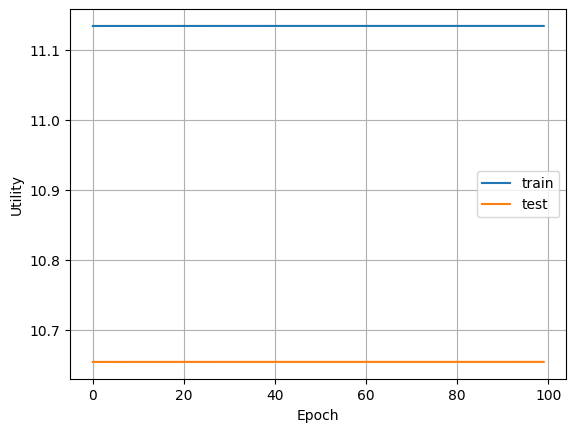

In [150]:
plt.plot(torch.stack(train_utility).detach().numpy(), label='train')
plt.plot(torch.stack(test_utility).detach().numpy(), label='test')
plt.xlabel('Epoch')
plt.ylabel('Utility')
plt.grid()
plt.legend()

In [138]:
loss_fn(Z, X, N)

(tensor(-8.7234, dtype=torch.float64, grad_fn=<NegBackward0>),
 tensor(8.7234, dtype=torch.float64, grad_fn=<SumBackward0>))

In [139]:
exh_solver(V_H, None, V_H*[N], X, list(hyp['E'].values()))

(tensor(9.7985, dtype=torch.float64), [0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

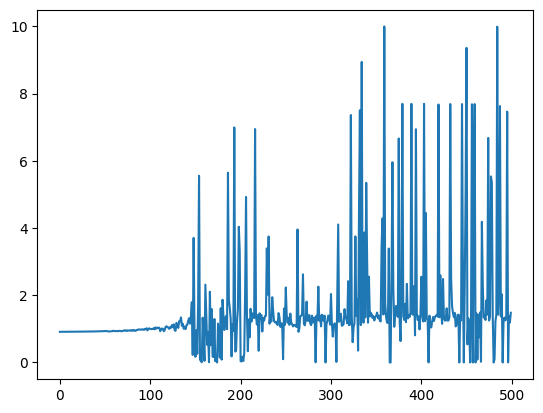

In [16]:
plt.plot(torch.stack(HyperGCN['utility']).detach().numpy())